# Deep Feature Analysis on Weather Webcam Dataset

In [16]:
import os
import glob
import scipy.io as io
import numpy as np
import sklearn
import sklearn.svm
import sys
import matplotlib.pyplot as plt
%matplotlib inline 
import pylab
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc, confusion_matrix
import sklearn.decomposition

In [2]:
caffe_root = '/Users/jillwang/Documents/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
#sys.path.insert(0, caffe_root + 'python')
import caffe

Set path

In [3]:
project_root = os.path.expanduser('~/Documents/Deep-Features-or-Not/')
VGG16_caffemodel_path = os.path.join(project_root, 'VGG16','VGG_ILSVRC_16_layers.caffemodel')
VGG16_deploy_path = os.path.join(project_root, 'VGG16','VGG_ILSVRC_16_layers_deploy.prototxt')
alex_deploy_path = os.path.join(caffe_root, 'models/bvlc_reference_caffenet/deploy.prototxt')
alex_caffemodel_path = os.path.join(caffe_root, 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
data_root = os.path.join(project_root, 'Weather')

Set CPU/GPU mode

In [4]:
gpu_id = None
if gpu_id != None:
    caffe.set_device(0)  # if we have multiple GPUs, pick the first one
    caffe.set_mode_gpu()
else:
    caffe.set_mode_cpu()

## Data Preparation

prepare the images

In [5]:
def get_labels(pos_fnames, neg_fnames):
    '''
    generate positive and negative labels in ndarrays
    '''
    assert isinstance(pos_fnames, list) and isinstance(neg_fnames, list)

    pos_lab = np.ones(len(pos_fnames))
    neg_lab = np.zeros(len(neg_fnames))
    labels = np.concatenate([pos_lab,neg_lab])
    return labels

In [6]:
neg_img_fnames = sorted(glob.glob(os.path.join(data_root, 'train', 'noRain', '*n*.jpg')))
pos_img_fnames = sorted(glob.glob(os.path.join(data_root, 'train', 'rain', '*r*.jpg')))
print "number of rain images: ", len(pos_img_fnames)
print "number of no rain images: ", len(neg_img_fnames)

number of rain images:  6059
number of no rain images:  17915


Downsampling the images (optional)

In [7]:
neg_img_fnames = random.sample(neg_img_fnames, 8000)
pos_img_fnames = random.sample(pos_img_fnames, 4000)

Cross_validation Splitting

In [8]:
img_fnames = pos_img_fnames + neg_img_fnames 
lab = get_labels(pos_img_fnames, neg_img_fnames)
X_train, X_test, y_train, y_test = train_test_split(img_fnames, lab, test_size=0.2)

## Model Preparation

prepare the image mean file

In [9]:
mean_npy = None
if mean_npy is None:
    mean_npy = caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy'
    print('Using imagenet mean pixel')
else:
    print('Using custom mean')

Using imagenet mean pixel


Init caffe model and the input image dimension

In [10]:
def init(caffe_deploy_prototxt, caffe_weights, mean_npy, image_dims=[256, 256]):
    '''
    Sets up deploy version of the caffe model in python according to caffe_deploy_prototxt, 
    and loads the pretrained/finetuned weights from caffe_weights (a .caffemodel file)
    mean_npy is the mean image over the dataset.
    Set up input preprocessing the same as in "00-classification"
    '''
    net = caffe.Classifier(caffe_deploy_prototxt, caffe_weights, image_dims = image_dims)
    # input preprocessing: 'data' is the name of the input blob == net.inputs[0]
    net.transformer.set_mean('data', np.load(mean_npy).mean(1).mean(1)) # mean pixel
    net.transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
    net.transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
    return net

In [11]:
caffe_deploy_prototxt = VGG16_deploy_path
caffe_weights = VGG16_caffemodel_path
net = init(caffe_deploy_prototxt, caffe_weights, mean_npy)

## Feature Extraction from Scratch

In [54]:
layers_to_extract = ['pool3']

Image cropping and preprocessing

In [55]:
def getDeepFeatureLayers(net, imgPath, layers, isRandomCrop = False):
    
    def preprocess(net, imgPath):
        '''
        preprocess the image by resizing it to image_dims and performing one of the croppings in a random way:
        center, corners, and mirrors
        '''
        input_ = caffe.io.load_image(imgPath)
        input_ = caffe.io.resize_image(input_, net.image_dims)
        input_ = caffe.io.oversample(input_[np.newaxis,:], net.crop_dims)
        if isRandomCrop:
            input_ = randomCrop(input_)
        caffe_in = np.zeros(np.array(input_.shape)[[0, 3, 1, 2]],
                    dtype=np.float32)
        for ix, in_ in enumerate(input_):
            caffe_in[ix] = net.transformer.preprocess('data', in_)

        return caffe_in
    
    def randomCrop(in_):
        '''
        selecting one of the croppings in a random way (center, corners, and mirrors)
        in_ : image data with augmentation (10 crops)
        '''        
        index = np.random.randint(10, size = len(in_)/10) + np.array(range(0, len(in_)/10))*10
        in_ = in_[index] 
        
        return in_
    
    def accessBlob(net, layer):
        deep_feature = net.blobs[layer].data
        deep_feature = deep_feature.squeeze()
        if not isRandomCrop:
            deep_feature = deep_feature.mean(0)     

        if len(deep_feature.shape)>1:
            deep_feature=np.hstack(np.hstack(deep_feature))
        return deep_feature
    
    if isRandomCrop:
        net.blobs['data'].reshape(1, 3, net.crop_dims[0], net.crop_dims[1])
    else:
        net.blobs['data'].reshape(10, 3, net.crop_dims[0], net.crop_dims[1])            
    out = net.forward_all(**{'data': preprocess(net, imgPath)})
    df = [accessBlob(net, layer) for layer in layers]    
    return df

In [56]:
def retrieve_features(net, img_fnames, layer, isRandomCrop = False):
    '''
    Takes images in img_fnames, gets the neural activations of each image
    in layer, and returns a numpy matrix, saving the individual features along the way
    '''


    assert isinstance(img_fnames, list)
    assert isinstance(layer, list)
    print("Getting {} layer features".format(layer))    

    f1 = getDeepFeatureLayers(net, img_fnames[0], layer, isRandomCrop)
    nfet = len(layer)
    features = []
    for i in range(nfet):
        dim = np.atleast_1d(f1[i]).shape[0]
        features = features + [np.zeros((len(img_fnames), dim), dtype = np.float64, order = 'C')]

    for i, fname in enumerate(img_fnames):
        for j in range(nfet):
            features[j][i, :] = np.atleast_1d(getDeepFeatureLayers(net, fname, layer, isRandomCrop)[j])
        if i % (len(img_fnames)/50) == 0:
            print("{:2.2f}% of the computation has done.".format(float(i)/len(img_fnames)*100))
        
    return features

Feature extraction starts...

In [57]:
fet = retrieve_features(net, X_train, layers_to_extract, isRandomCrop = True)
tst_fet = retrieve_features(net, X_test, layers_to_extract, isRandomCrop = True)

Getting ['pool3'] layer features
0.00% of the computation has done.
2.00% of the computation has done.
4.00% of the computation has done.
6.00% of the computation has done.
8.00% of the computation has done.
10.00% of the computation has done.
12.00% of the computation has done.
14.00% of the computation has done.
16.00% of the computation has done.
18.00% of the computation has done.
20.00% of the computation has done.
22.00% of the computation has done.
24.00% of the computation has done.
26.00% of the computation has done.
28.00% of the computation has done.
30.00% of the computation has done.
32.00% of the computation has done.
34.00% of the computation has done.
36.00% of the computation has done.
38.00% of the computation has done.
40.00% of the computation has done.
42.00% of the computation has done.
44.00% of the computation has done.
46.00% of the computation has done.
48.00% of the computation has done.
50.00% of the computation has done.
52.00% of the computation has done.


## Write Feature to the File

In [28]:
def write_features(dflist, img_fnames, layers, save_directory):
    assert isinstance(img_fnames, list)
    assert isinstance(layers, list)
    for layer in layers:
        layer_directory = os.path.join(save_directory, layer)
        if not os.path.isdir(layer_directory):
            os.makedirs(layer_directory)

    print("extracting")
    n = len(img_fnames)
    for i, fname in enumerate(img_fnames):
        name = os.path.basename(fname)[:-4]
        compute = False
        for layer in layers:
            out_file = os.path.join(save_directory, layer, name + '.txt')
            if not os.path.isfile(out_file):
                compute = True # in case any of the features is not computed, we just extract them all
                break
        if compute:
            #print(save_directory)
            #print("{}, {} of {}".format(name, i, n))
            for df, layer in zip(dflist, layers):
                df = np.atleast_1d(df[i,])
                out_file = os.path.join(save_directory, layer, name + '.txt')
                if not os.path.isfile(out_file):
                    with open(out_file,'w') as f:
                        for idx in range(df.shape[0]):
                            f.write('%5.10f ' % df[idx])



In [29]:
write_features(fet, X_train, ['pool5'], os.path.join(data_root, 'train_feature'))
write_features(tst_fet, X_test, ['pool5'], os.path.join(data_root, 'tst_feature'))

extracting


IOError: [Errno 28] No space left on device

In [33]:
print fet[0].shape

(9600, 200704)


## Classifier

In [58]:
cls_opts = {
    'SVM': {
            'C': 1,
            'kernel': 'linear',
            'probability': True
            },
    'Logistic': {
                'C': 1,
                'penalty': 'l1'
                }
    }

In [61]:
def eval_cls(X, y, X_test, cls_name, normalize = True, dimReduction = False, cls_opts_dict = cls_opts):        
    '''
    predict classification probability with designated classifier name and its parameters
    '''
    num_classes = len(np.unique(y))
    
    def call_svc():
        return sklearn.svm.SVC(**cls_opts_dict[cls_name])
    
    def call_loglc():
        return sklearn.linear_model.LogisticRegression(**cls_opts_dict[cls_name])
    
    classifiers = {
        'SVM': call_svc,
        'Logistic': call_loglc
    }
    
    cls = classifiers[cls_name]()

    if normalize:
        scaler = sklearn.preprocessing.StandardScaler().fit(X)
        X = scaler.transform(X) 
        X_test = scaler.transform(X_test)
        
    if dimReduction:
        pca = sklearn.decomposition.PCA(n_components = 500, whiten = True)
        X = pca.fit_transform(X)
        X_test = pca.transform(X_test)

    cls.fit(X, y)

    pred_labels = cls.predict_proba(X_test)

    return pred_labels


Choosing the layer from which the feature is extracted

In [62]:
layer_ = 'pool3'
ind = layers_to_extract.index(layer_)
print ind

0


Training begins....

In [ ]:
pred = eval_cls(fet[ind], y_train, tst_fet[ind], 'Logistic', dimReduction = True)

## Evaluation

Plot ROC curve

In [50]:
def roc_plot(fpr, tpr, auc, classifier):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(classifier + ' ROC')
    plt.legend(loc="lower right")
    plt.show()

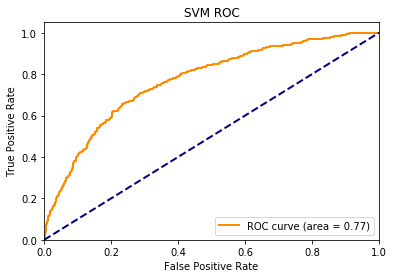

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, pred[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)
roc_plot(fpr, tpr, roc_auc, 'SVM')

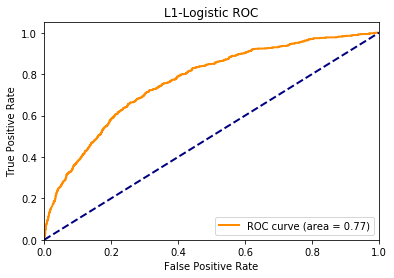

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, pred[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)
roc_plot(fpr, tpr, roc_auc, 'L1-Logistic')

Make a copy of the prediction probability

In [401]:
y_pred = pred[:, 1]

Accuracy and FP

In [402]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
print "Accuracy is: ", accuracy_score(y_test, y_pred)
print "The percentage of true rain: ", precision_score(y_test, y_pred)

Accuracy is:  0.725416666667
The percentage of true rain:  0.591121495327
